# Overview
Use this notebook to convert an OCT image to virtual histology.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/measure_iou_for_interactive_segmentation.ipynb) and run.


## Set Up Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
image_directory = '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/'

Mounted at /content/drive/


In [2]:
#segment anything (sam)
using_colab = True
visualize_sam_outputs = True

#sam algorithm input parameters
points_per_side=32
pred_iou_thresh=0.90
stability_score_thresh=0.95
crop_n_layers=1
crop_n_points_downscale_factor=2
min_mask_region_area=3000

#sam model type and weights checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [3]:
rf_api_key= "R04BinsZcBZ6PsfKR2fP"
rf_workspace= "yolab-kmmfx"
rf_project = "11-16-2023-zero-shot-oct"
rf_dataset = "coco-segmentation" #"png-mask-semantic"
rf_version = 3

In [4]:
import torch
import torchvision
!git clone --recurse-submodules https://github.com/WinetraubLab/zero_shot_segmentation.git
%run /content/zero_shot_segmentation/setup_roboflow_and_sam.ipynb


DEVICE = torch.device('cuda')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
predictor = SamPredictor(sam)

Cloning into 'zero_shot_segmentation'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 262 (delta 60), reused 44 (delta 17), pack-reused 160
Receiving objects: 100% (262/262), 23.52 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (127/127), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 877.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 11/16/2023-Zero-shot-OCT-3 in coco-segmentation:: 100%|██████████| 17/17 [00:00<00:00, 2390.24it/s]


/content/11/16/2023-Zero-shot-OCT-3/test
/content/11/16/2023-Zero-shot-OCT-3/test/_annotations.coco.json
PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7dsri6w0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7dsri6w0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=7b2438c77c1ed575005439bd26ebf62c6d18b89d330ccb2f26b52631cb49940e
  Stored in directory: /tmp/pip-ephem-wheel-cache-i0brv5de/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-11-25 21:20:13--  https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg


In [5]:
#roboflow semantic classes
EPIDERMIS = True #mask values for epidermis mask

import numpy as np
from PIL import Image, ImageDraw

In [6]:
def coco_mask_to_numpy(image_shape, coco_mask):
    """
    Convert COCO format segmentation mask to a NumPy array.

    Parameters:
    - image_shape: Tuple (m, n) representing the shape of the image.
    - coco_mask: List of coordinates [x1, y1, x2, y2, ..., xn, yn] in COCO format.

    Returns:
    - numpy_mask: NumPy array of shape (m, n) with True within the mask boundaries and False elsewhere.
    """
    # Create an image and draw the polygon defined by the COCO mask
    mask_image = Image.new("1", image_shape[::-1], 0)
    draw = ImageDraw.Draw(mask_image)
    draw.polygon(coco_mask, outline=1, fill=1)
    del draw

    # Convert the mask image to a NumPy array
    numpy_mask = np.array(mask_image, dtype=bool)

    return numpy_mask

In [7]:
def download_images_and_masks(api_key, workspace, project_name, dataset_name, version):
    from roboflow import Roboflow
    rf = Roboflow(api_key=api_key)
    project = rf.workspace(workspace).project(project_name)
    dataset = project.version(version).download(rf_dataset, overwrite = False)
    return dataset

In [8]:
def calculate_iou(mask_true, mask_pred, class_id):
    #intersection = np.logical_and(mask_true == class_id, mask_pred == class_id)
    intersection = np.logical_and(mask_true, mask_pred == class_id)
    union = np.logical_or(mask_true, mask_pred == class_id)

    class_iou = np.sum(intersection) / np.sum(union)
    return class_iou

In [9]:
%pip install pylabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00


In [10]:
# Download images and masks
dataset = download_images_and_masks(rf_api_key, rf_workspace, rf_project, rf_dataset, rf_version)
# prepare model
DEVICE = torch.device('cuda')  # 'cpu'
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
predictor = SamPredictor(sam)


total_iou = 0
total_samples = 0
annot_dataset_dir = "/content/11/16/2023-Zero-shot-OCT-3/test"
raw_oct_dataset_dir = "/content/drive/Shareddrives/Yolab - Current Projects/Yonatan/Hist Images/"
real_histology_dir = raw_oct_dataset_dir
# Get the list of image files
image_files = [f for f in os.listdir(annot_dataset_dir) if f.endswith(".jpg")]

total_iou = {EPIDERMIS:0}  # DERMIS:0 , # IOU for each class
total_iou_oct = {EPIDERMIS:0}
total_samples = 0
path_to_annotations = os.path.join(annot_dataset_dir, "_annotations.coco.json")
from pylabel import importer
dataset = importer.ImportCoco(path_to_annotations, path_to_images=annot_dataset_dir, name="zero_shot_oct")
visualize = False
segment_oct = True
segment_real_hist = False

loading Roboflow workspace...
loading Roboflow project...


In [11]:
image_files = image_files[:2]


In [12]:
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference
!pip install -r ./OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix/requirements.txt

Cloning into 'OCT2Hist-ModelInference'...
remote: Enumerating objects: 785, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 785 (delta 158), reused 193 (delta 101), pack-reused 504
Receiving objects: 100% (785/785), 25.33 MiB | 23.24 MiB/s, done.
Resolving deltas: 100% (415/415), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 7.32 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.2 MB/s eta 0:00:00


In [15]:
sys.path.append('./zero_shot_segmentation')
sys.path.append('./OCT2Hist-ModelInference')
!cp -p "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/latest_net_G.pth" "/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix/checkpoints/oct2hist"


In [24]:
import matplotlib as mpl
!pip install ipympl
%matplotlib ipympl



In [25]:
visualize

False

Creating image embeddings ... Done


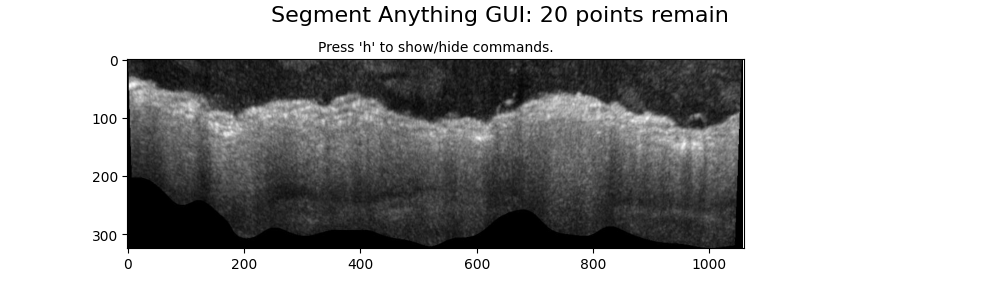

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [34]:
%matplotlib ipympl
from zero_shot_utils.run_sam_gui import run_gui_segmentation
img = "/content/11/16/2023-Zero-shot-OCT-3/test/LG-83-Slide03_Section03_yp0_A_jpg.rf.861f96ff9809f38699df443a02db9d6b.jpg"
oct_img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
weights_path = "/content/sam_vit_h_4b8939.pth"
run_gui_segmentation(oct_img, weights_path)

Creating image embeddings ... Done


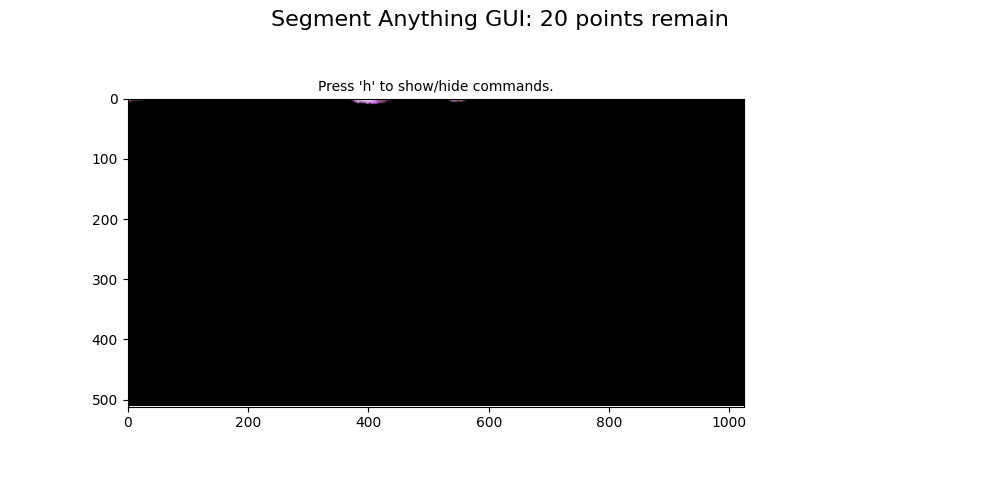

Could not segment /content/11/16/2023-Zero-shot-OCT-3/test/LG-83-Slide03_Section03_yp0_A_jpg.rf.861f96ff9809f38699df443a02db9d6b.jpg.
Creating image embeddings ... Done


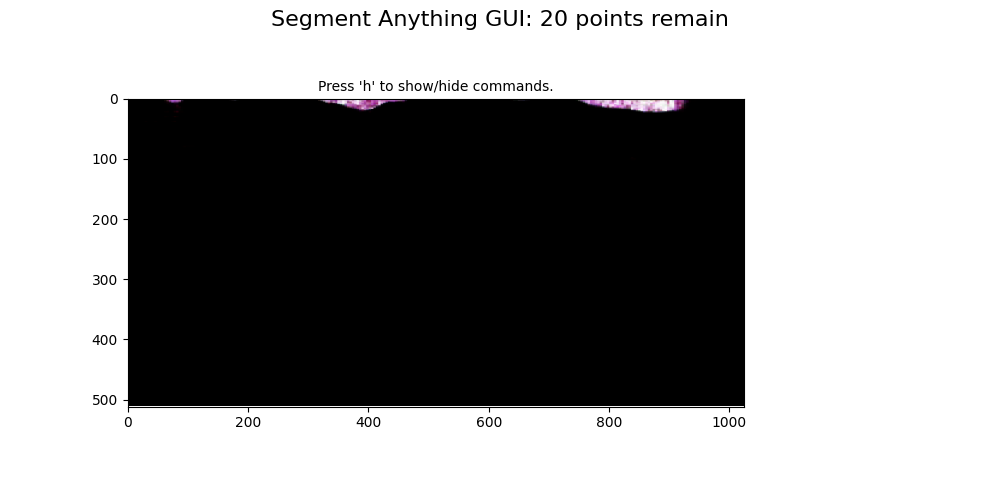

Could not segment /content/11/16/2023-Zero-shot-OCT-3/test/LG-44-Slide05_Section02_yp0_A_jpg.rf.08bf8f3b41f1b9714286832c22284838.jpg.


In [26]:
from tqdm import tqdm
import cv2
from zero_shot_utils.predict_mask_on_oct_interactive import predict
for image_file in image_files:
    gt_image_path = os.path.join(raw_oct_dataset_dir, image_file)
    image_path = os.path.join(annot_dataset_dir, image_file)
    oct_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    coco_mask = dataset.df.ann_segmentation[dataset.df.img_filename == image_file].values[0][0]
    mask_true = coco_mask_to_numpy(oct_img.shape, coco_mask)
    if visualize:
        plt.figure(figsize=(5, 5))
        plt.imshow(oct_img, cmap = "gray")
        show_mask(mask_true, plt.gca())
        plt.axis('off')
        plt.title(f"Input oct and annotation: {image_file}")
        plt.show()

    # Predict the mask using your model
    mask, masked_gel_image, crop_args = predict(image_path, predictor, weights_path = CHECKPOINT_PATH)

    # if segment_oct:
    #     oct_mask, _, crop_args = predict(image_path, predictor, weights_path=CHECKPOINT_PATH, vhist=False)

    # if segment_real_hist:
    #     image_path = os.path.join(real_histology_dir, image_file)
    #     oct_mask, _, crop_args = predict(image_path, predictor, weights_path=CHECKPOINT_PATH, vhist=False)

    if mask is None or mask.sum().sum()==0:
        print(f"Could not segment {image_path}.")
        continue
    mask[mask==1] = True
    mask[mask == 0] = False
    #mask_pred = cv2.resize(mask_pred, (mask_true.shape[1], mask_true.shape[0]), interpolation =  cv2.INTER_NEAREST)
    cropped_mask_gt = crop(mask_true, **crop_args)
    cropped_oct_image = crop(oct_img, **crop_args)
    from PIL import Image

    if visualize:
        plt.figure(figsize=(5, 5))
        plt.imshow(cropped_oct_image, cmap = "gray")
        show_mask(mask, plt.gca())
        show_mask(cropped_mask_gt, plt.gca(), random_color=True)
        plt.axis('off')
        plt.title(f"Cropped oct and segmentation: {image_file}")
        plt.show()

    # Calculate IoU for each class
    for class_id in [EPIDERMIS]: # DERMIS
        epidermis_iou_vhist = calculate_iou(cropped_mask_gt, mask, class_id)
        if segment_oct:
            epidermis_iou_oct = calculate_iou(cropped_mask_gt, oct_mask, class_id)
            total_iou_oct[class_id] += epidermis_iou_oct
        total_iou[class_id] += epidermis_iou_vhist

    total_samples += 1


In [ ]:

average_iou = total_iou[EPIDERMIS] / total_samples #sum all ious divided by (number of images * number of classes).
print(f"Average IoU with virtual histology: {average_iou}")
if segment_oct:
    average_iou_oct = total_iou_oct[EPIDERMIS] / total_samples
    print(f"Average IoU without virtual histology: {average_iou_oct}")

In [ ]:
sys.path.append('./zero_shot_segmentation')
sys.path.append('./OCT2Hist-ModelInference')

import oct2hist
from utils.show_images import *
# Set up the network environment
oct2hist.setup_network()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import oct2hist
from utils.show_images import *
from utils.crop import crop


In [ ]:
import random
import os
# List all files in the directory
all_images = os.listdir(image_directory)

# Filter out images without the suffix _realB
filtered_images = [img for img in all_images if "real_A" in img]
random.shuffle(filtered_images)
filtered_images = filtered_images[:10]

# Uncomment this part if you would like to try a single image rather than all.
#filtered_images = [''] # for one good example: ['LG-37-Slide06_Section02_yp0_patch01_real_A.png']

In [ ]:
# -*- coding: utf-8 -*-
"""run_oct2hist.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/github/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist.ipynb

# Overview
Use this notebook to convert an OCT image to virtual histology.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist.ipynb) and run.
"""

import random
import sys
from utils.show_images import showImg

import torch
from segment_anything import sam_model_registry, SamPredictor

import oct2hist
from utils.masking import get_sam_input_points, show_points, show_mask, mask_gel_and_low_signal

# from google.colab import drive

import cv2
import matplotlib.pyplot as plt

import os

for filename in filtered_images:
    oct_input_image_path = os.path.join(image_directory, filename)
    # Load OCT image
    oct_image = cv2.imread(oct_input_image_path)
    oct_image = cv2.cvtColor(oct_image, cv2.COLOR_BGR2RGB)
    #is it sheered?
    right_column = oct_image.shape[1]-1
    if (oct_image[:,0,0] == 0).all() or (oct_image[:,right_column,0] == 0).all():
        continue
    # OCT image's pixel size
    microns_per_pixel_z = 1
    microns_per_pixel_x = 1

    # no need to crop - the current folder contains pre cropped images.
    # cropped = crop_oct(oct_image)

    #workaround: for some reason the images look close to the target shape, but not exactly.
    oct_image = cv2.resize(oct_image, [1024, 512], interpolation=cv2.INTER_AREA)

    #for good input points, we need the gel masked out.
    masked_gel_image = mask_gel_and_low_signal(oct_image)

    # run vh&e
    virtual_histology_image, _, o2h_input = oct2hist.run_network(oct_image,
                                                                                             microns_per_pixel_x=microns_per_pixel_x,
                                                                                             microns_per_pixel_z=microns_per_pixel_z)
    # mask
    input_point, input_label = get_sam_input_points(masked_gel_image, virtual_histology_image)

    predictor.set_image(virtual_histology_image)
    masks, scores, logits = predictor.predict(point_coords=input_point, point_labels=input_label,
                                              multimask_output=False, )

    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(5, 5))
        plt.imshow(virtual_histology_image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i + 1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()
    print(f"Image {filename} ready.")
